In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# Setup
from dotenv import load_dotenv
import os
from langchain_core.messages import HumanMessage
from graph.trivial_agent_graph import IndexerAgentGraphBuilder
from agents.IndexerAgent import indexer_agent_model, tool_executor
from tools.JavaScriptRunner import tool_js_on_block_schema_func, tool_js_on_block_schema
from agents.BlockExtractorAgent import run_js_on_block_only_schema,JsResponse
import json

# Load .env file
load_dotenv('.env')

# Set model variables
OPENAI_BASE_URL = "https://api.openai.com/v1"
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OPENAI_ORGANIZATION = os.getenv("OPENAI_ORGANIZATION")


os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGCHAIN_PROJECT")

/Users/spark_near/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [8]:
from typing import TypedDict, Sequence
from langchain_core.messages import BaseMessage

# Define Graphstate
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        messages: With user questions, tracking plans, reasoning
        block_heights: Block heights of the blocks to be parsed
        js_code: Javascript code to be run on block schema
        block_schema: Extracted block schema from json of blocks 
        ddl_code: Data Definition Language code for creating tables
        dml_code: Data manipulation language code for inserting data using context.db
        iterations: Number of tries to generate the code
        error: error message if any
        should_continue: Binary flag for control flow to indicate whether to continue or not
    """

    messages: Sequence[BaseMessage] #changed from List
    block_heights: Sequence[int]
    block_schema: str
    js_code: str
    ddl_code: str
    dml_code: str
    iterations: int
    error: str
    should_continue: bool

In [9]:
# Load agents
from tools.NearLake import tool_get_block_heights
from agents.BlockExtractorAgent import BlockExtractorAgent,block_extractor_agent_model
from agents.DDLAgent import DDLCodeAgent,ddl_code_model
from langgraph.prebuilt import ToolExecutor

# Block Extractor Agent
block_extractor_tools = [tool_js_on_block_schema_func, tool_get_block_heights]
block_extractor_model = block_extractor_agent_model(block_extractor_tools)
block_extractor_agent = BlockExtractorAgent(block_extractor_model,ToolExecutor(block_extractor_tools))

# DDL Agent
ddl_tools=[tool_js_on_block_schema]
ddl_code_agent_model = ddl_code_model(ddl_tools)
ddl_code_agent = DDLCodeAgent(ddl_code_agent_model,ToolExecutor(ddl_tools))

In [10]:
# Conditional Edge logic
def should_block_schema_continue(state):
    last_message = state["messages"][-1]
    # If there are no tool calls, then we finish
    if "tool_calls" not in last_message.additional_kwargs:
        return "end"
    # If there is a Response tool call, then we finish
    elif any(
        tool_call["function"]["name"] == JsResponse.__name__
        for tool_call in last_message.additional_kwargs["tool_calls"]
    ):
        return "end"
    # Otherwise, we continue
    else:
        return "continue"   
    
def block_schema_review_continue(state):
    should_continue = state['should_continue']
    block_schema = state['block_schema']
    iterations = state['iterations']
    if should_continue == True:
        return "continue"
    elif iterations > 3:
        return "end"
    elif block_schema == "":
        return "repeat"
    else:
        return "end"
    

In [11]:
## Create Final Graph (will move this to another file ultimately)
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

## Define the Agent nodes
workflow.add_node("block_extractor_agent", block_extractor_agent.call_model)  # Plan the process
workflow.add_node("ddl_code_agent", ddl_code_agent.call_model)  # Plan the process

## Tool Nodes
workflow.add_node("get_block_schema",block_extractor_agent.call_tool)
workflow.add_node("parse_blocks",ddl_code_agent.call_tool)

## Human Review
workflow.add_node("review_schema",block_extractor_agent.human_review)

## Add Edges
workflow.set_entry_point("block_extractor_agent")
workflow.add_edge("get_block_schema", "block_extractor_agent")
workflow.add_edge("parse_blocks", "ddl_code_agent")

# Add Conditional Edges
# Check if all block extraction tools are completed
workflow.add_conditional_edges(
    "block_extractor_agent",
    should_block_schema_continue,
    {
        "continue":"get_block_schema",
        "end": "review_schema"
    }   
)
# Check if block schema is correct via human review
workflow.add_conditional_edges(
    "review_schema",
    block_schema_review_continue,
    {
        "continue":"ddl_code_agent",
        "repeat": "block_extractor_agent",
        "end": END
    }   
)
# Check if DDL has finished tool calls
workflow.add_conditional_edges(
    "ddl_code_agent",
    should_block_schema_continue,
    {
        "continue":"parse_blocks",
        "end": END
    }   
)

app = workflow.compile()

In [13]:
from langchain_core.messages import HumanMessage

question = """
    Extract all FunctionCalls where receiverId is 'app.nearcrowd.near'. For each function call, 
    I need signerId, block height, receiptId, block datetime, methodName. Also add all fields from 
    args that are decoded from base64-encoded JSON. I only need actions for successful receipts.
"""

result = app.invoke({"messages": [HumanMessage(content=question)], 
                     "block_schema": "",
                     "js_code":"",
                     "ddl_code":"",
                     "dml_code": "",
                     "iterations": 0,
                     "error":"",
                     "should_continue": False,
                     })

print(result)

In [10]:
result['block_schema']

CREATE TABLE result (
    id SERIAL PRIMARY KEY,
    first_name TEXT,
    last_name TEXT,
    email TEXT,
    gender TEXT,
    ip_address TEXT,
    city TEXT,
    state TEXT,
    country TEXT,
    language TEXT,
    age INTEGER,
    credit_card TEXT,
    date DATE
);


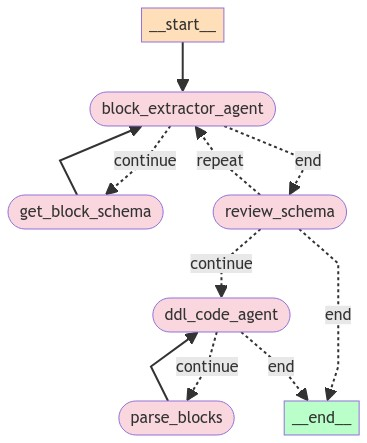

In [18]:
# Visualization
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))